In [1]:
# Data preprocessing
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import os
import json

# Plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, ConnectionPatch, Circle, Arc
%matplotlib inline
import seaborn as sns
import scikitplot as skplt
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import networkx as nx

%load_ext autoreload
%autoreload 2

In [2]:
from parser import Competitions, Events, Matches, Lineups

In [3]:
comps = Competitions().get_data()
comps

,competition_gender,competition_id,competition_name,country_name,match_available,match_updated,season_id,season_name
0,female,37,FA Women's Super League,England,2019-12-03T03:42:59.581,2019-12-03T03:42:59.581,42,2019/2020
1,female,37,FA Women's Super League,England,2019-10-27T11:05:58.079,2019-10-27T11:05:58.079,4,2018/2019
2,male,43,FIFA World Cup,International,2019-06-23T12:38:35.142,2019-06-23T12:38:35.142,3,2018
3,male,11,La Liga,Spain,2019-11-20T10:20:40.270,2019-11-20T10:20:40.270,27,2015/2016
4,male,11,La Liga,Spain,2019-07-30T12:42:05.563,2019-07-30T12:42:05.563,26,2014/2015
5,male,11,La Liga,Spain,2019-07-24T19:44:48.866,2019-07-24T19:44:48.866,25,2013/2014
6,male,11,La Liga,Spain,2019-07-29T17:46:18.935,2019-07-29T17:46:18.935,24,2012/2013
7,male,11,La Liga,Spain,2019-08-27T09:48:17.842,2019-08-27T09:48:17.842,23,2011/2012
8,male,11,La Liga,Spain,2019-11-20T07:58:16.722,2019-11-20T07:58:16.722,22,2010/2011
9,male,11,La Liga,Spain,2019-07-11T07:44:14.533,2019-07-11T07:44:14.533,21,2009/2010


In [4]:
wwc_matches = Matches(competition_id = '72', season_id = '30').get_data()

In [22]:
netherlands = ((wwc_matches['away_team.country.name'] == 'Netherlands') | \
               (wwc_matches['home_team.country.name'] == 'Netherlands'))
netherlands_games = wwc_matches.loc[netherlands]
netherlands_ids = netherlands_games['match_id']

In [18]:
def identify_half(row):
    if row['timestamp'].total_seconds() <= (row['minute'] * 60):
        return 'second'
    return 'first'

In [335]:
def draw_pitch_dark(ax):

    #Pitch Outline & Centre Line
    pitch = Rectangle([0,0], width = 120, height = 80, fill = False)
    center_line = ConnectionPatch([60, 0], [60, 80], 'data')

    #Penalty boxes
    left_penalty = Rectangle([0, 18], width = 18, height = 44, fill = False)
    right_penalty = Rectangle([102, 18], width = 18, height = 44, fill = False)

    #Six-yard box
    left_box = Rectangle([0, 30], width = 6, height = 20, fill = False)
    right_box = Rectangle([114, 30], width = 6, height = 20, fill = False)

    #Penalty spots
    left_spot = Circle([12, 40], 1, color = 'black')
    right_spot = Circle([108, 40], 1, color = 'black')

    #Center circle
    center_circle = Circle([60, 40], 9.15, fill = False)
    center_spot = Circle([60, 40], 1, color = 'black')

    #Arcs
    left_arc = Arc([12, 40], height = 18.3, width = 18.3, angle = 0, theta1 = 310, theta2 = 50)
    right_arc = Arc([108, 40], height = 18.3, width = 18.3, angle = 0, theta1 = 130, theta2 = 230)

    #Goals
    left_goal = Rectangle([-2.42, 36], height = 8, width = 2.42, fill = False)
    right_goal = Rectangle([120, 36], height = 8, width = 2.42, fill = False)

    #Corner arcs
    bottom_left = Arc([0, 0], height = 2, width = 2, angle = 0, theta1 = 0, theta2 = 90)
    top_left = Arc([0, 80], height = 2, width = 2, angle = 0, theta1 = 270, theta2 = 0)
    bottom_right = Arc([120, 0], height = 2, width = 2, angle = 0, theta1 = 90, theta2 = 180)
    top_right = Arc([120, 80], height = 2, width = 2, angle = 0, theta1 = 180, theta2 = 270)

    pitch_elements = [pitch, center_line, left_penalty, right_penalty,
                      left_box, right_box, left_spot, right_spot,
                      center_circle, center_spot, left_arc, right_arc,
                      left_goal, right_goal, bottom_left, top_left,
                      bottom_right, top_right]

    for element in pitch_elements:
        ax.add_patch(element)

In [330]:
def draw_pitch_light(ax):

    #Pitch Outline & Centre Line
    pitch = Rectangle([0,0], width = 120, height = 80, fill = False, color = 'white')
    center_line = ConnectionPatch([60, 0], [60, 80], 'data', color = 'white')

    #Penalty boxes
    left_penalty = Rectangle([0, 18], width = 18, height = 44, fill = False, color = 'white')
    right_penalty = Rectangle([102, 18], width = 18, height = 44, fill = False, color = 'white')

    #Six-yard box
    left_box = Rectangle([0, 30], width = 6, height = 20, fill = False, color = 'white')
    right_box = Rectangle([114, 30], width = 6, height = 20, fill = False, color = 'white')

    #Penalty spots
    left_spot = Circle([12, 40], 1, color = 'white')
    right_spot = Circle([108, 40], 1, color = 'white')

    #Center circle
    center_circle = Circle([60, 40], 9.15, fill = False, color = 'white')
    center_spot = Circle([60, 40], 1, color = 'white')

    #Arcs
    left_arc = Arc([12, 40], height = 18.3, width = 18.3, angle = 0, theta1 = 310, theta2 = 50, color = 'white')
    right_arc = Arc([108, 40], height = 18.3, width = 18.3, angle = 0, theta1 = 130, theta2 = 230, color = 'white')

    #Goals
    left_goal = Rectangle([-2.42, 36], height = 8, width = 2.42, fill = False, color = 'white')
    right_goal = Rectangle([120, 36], height = 8, width = 2.42, fill = False, color = 'white')

    #Corner arcs
    bottom_left = Arc([0, 0], height = 2, width = 2, angle = 0, theta1 = 0, theta2 = 90, color = 'white')
    top_left = Arc([0, 80], height = 2, width = 2, angle = 0, theta1 = 270, theta2 = 0, color = 'white')
    bottom_right = Arc([120, 0], height = 2, width = 2, angle = 0, theta1 = 90, theta2 = 180, color = 'white')
    top_right = Arc([120, 80], height = 2, width = 2, angle = 0, theta1 = 180, theta2 = 270, color = 'white')

    pitch_elements = [pitch, center_line, left_penalty, right_penalty,
                      left_box, right_box, left_spot, right_spot,
                      center_circle, center_spot, left_arc, right_arc,
                      left_goal, right_goal, bottom_left, top_left,
                      bottom_right, top_right]

    for element in pitch_elements:
        ax.add_patch(element)

In [151]:
netherlands_games[['away_team.country.name','home_team.country.name', 'match_id']]

,away_team.country.name,home_team.country.name,match_id
8,Netherlands,New Zealand,22942
28,Canada,Netherlands,68344
37,Cameroon,Netherlands,22964
42,Japan,Netherlands,69188
47,Sweden,Netherlands,69284
49,Netherlands,Italy,69205
51,Netherlands,United States of America,69321


In [31]:
group_nz = Events(match_id = 22942).get_player_data('Vivianne Miedema')
group_canada = Events(match_id = 68344).get_player_data('Vivianne Miedema')
group_cameroon = Events(match_id = 22964).get_player_data('Vivianne Miedema')

roe = Events(match_id = 69188).get_player_data('Vivianne Miedema')
quarter = Events(match_id = 69205).get_player_data('Vivianne Miedema')
semi = Events(match_id = 69284).get_player_data('Vivianne Miedema')
final = Events(match_id = 69321).get_player_data('Vivianne Miedema')

In [95]:
matches = [group_nz, group_canada, group_cameroon, roe, quarter, semi, final]
opponents = ['New_Zealand', 'Canada', 'Cameroon', 'Japan', 'Italy', 'Sweden', 'USA']

In [229]:
type(None)

NoneType

In [234]:
# def pass_map(matches, opponents, df = None):

#     for i in range(len(matches)):
#         game = matches[i]

#         passes = game.loc[game['type.name'] == 'Pass'].copy()
#         passes.loc[:, 'timestamp'] = pd.to_timedelta(passes.loc[:, 'timestamp'])
#         passes.loc[:, 'half'] = passes.apply(identify_half, axis = 1)

#         fig = plt.figure()
#         fig.set_size_inches(15, 10)
#         ax = fig.add_subplot(1, 1, 1)
        
#         if type(df) == pd.DataFrame:
#             title_string = (df.iloc[i]['home_team.country.name'] + " v. " + df.iloc[i]['away_team.country.name']\
#                  + ": " + str(df.iloc[i]['home_score']) + ' - ' + str(df.iloc[i]['away_score']))
            
#             font = {'family': 'sans serif',
#             'color':  'black',
#             'weight': 'normal',
#             'size': 16,
#             }
            
#             plt.title(title_string, pad = 15, fontdict = font)


#         sns.kdeplot([x[0] for x in passes['location']], [x[1] for x in passes['location']], shade = True, color = 'green')

#         first_half = passes.loc[(passes['period'] == 1)]
#         second_half = passes.loc[(passes['period'] == 2)]
#         extra_time = passes.loc[(passes['period'].isin([3, 4])) & (passes['pass.outcome.name'] != 'Incomplete')]

#         # second_half['pass.end_location'] = second_half['pass.end_location'].apply(lambda x: [(120 - x[0]), x[1]])
#         # second_half['location'] = second_half['location'].apply(lambda x: [(120 - x[0]), x[1]])

#         for j in range(len(first_half)):
#             if first_half.iloc[j]['pass.outcome.name'] == 'Incomplete':
#                 ax.annotate("",
#                         xy = (first_half.iloc[j]['pass.end_location'][0], first_half.iloc[j]['pass.end_location'][1]), xycoords='data',
#                         xytext=(first_half.iloc[j]['location'][0], first_half.iloc[j]['location'][1]), textcoords='data',
#                         arrowprops=dict(arrowstyle="->",
#                                         color='yellow')
#                        )
#             else:
#                 ax.annotate("",
#                             xy = (first_half.iloc[j]['pass.end_location'][0], first_half.iloc[j]['pass.end_location'][1]), xycoords='data',
#                             xytext=(first_half.iloc[j]['location'][0], first_half.iloc[j]['location'][1]), textcoords='data',
#                             arrowprops=dict(arrowstyle="->",
#                                             color='blue')
#                            )

#         for k in range(len(second_half)):
#             if second_half.iloc[k]['pass.outcome.name'] == 'Incomplete':
#                 ax.annotate("",
#                         xy = (second_half.iloc[k]['pass.end_location'][0], second_half.iloc[k]['pass.end_location'][1]), xycoords='data',
#                         xytext=(second_half.iloc[k]['location'][0], second_half.iloc[k]['location'][1]), textcoords='data',
#                         arrowprops=dict(arrowstyle="->",
#                                         color='yellow')
#                        )
#             else:
#                 ax.annotate("",
#                             xy = (second_half.iloc[k]['pass.end_location'][0], second_half.iloc[k]['pass.end_location'][1]), xycoords='data',
#                             xytext=(second_half.iloc[k]['location'][0], second_half.iloc[k]['location'][1]), textcoords='data',
#                             arrowprops=dict(arrowstyle="->",
#                                             color='red')
#                            )

#         for l in range(len(extra_time)):
#             if extra_time.iloc[l]['pass.outcome.name'] == 'Incomplete':
#                 ax.annotate("",
#                         xy = (extra_time.iloc[l]['pass.end_location'][0], extra_time.iloc[l]['pass.end_location'][1]), xycoords='data',
#                         xytext=(extra_time.iloc[l]['location'][0], extra_time.iloc[l]['location'][1]), textcoords='data',
#                         arrowprops=dict(arrowstyle="->",
#                                         color='yellow')
#                        )
#             else:
#                 ax.annotate("",
#                             xy = (second_half.iloc[l]['pass.end_location'][0], second_half.iloc[l]['pass.end_location'][1]), xycoords='data',
#                             xytext=(second_half.iloc[l]['location'][0], second_half.iloc[l]['location'][1]), textcoords='data',
#                             arrowprops=dict(arrowstyle="->",
#                                             color='magenta')
#                            )

#         plt.ylim(-0.5, 80.5)
#         plt.xlim(-3, 123)

#         draw_pitch(ax)

#         plt.axis('off')
#         plt.show()

#         filename = 'maps/' + opponents[i] + '.png'

#         fig.savefig(filename, transparent=True)

In [ ]:
# def pass_map(matches, opponents, df = None):

#     for i in range(len(matches)):
#         game = matches[i]

#         passes = game.loc[game['type.name'] == 'Pass'].copy()
#         passes.loc[:, 'timestamp'] = pd.to_timedelta(passes.loc[:, 'timestamp'])
#         passes.loc[:, 'half'] = passes.apply(identify_half, axis = 1)

#         fig = plt.figure()
#         fig.set_size_inches(15, 10)
#         ax = fig.add_subplot(1, 1, 1)
        
#         if type(df) == pd.DataFrame:
#             title_string = (df.iloc[i]['home_team.country.name'] + " v. " + df.iloc[i]['away_team.country.name']\
#                  + ": " + str(df.iloc[i]['home_score']) + ' - ' + str(df.iloc[i]['away_score']))
            
#             font = {'family': 'sans serif',
#             'color':  'black',
#             'weight': 'normal',
#             'size': 16,
#             }
            
#             plt.title(title_string, pad = 15, fontdict = font)


#         sns.kdeplot([x[0] for x in passes['location']], [x[1] for x in passes['location']], shade = True, color = 'green',
#                     n_levels = 30)

#         first_half = passes.loc[(passes['period'] == 1)]
#         second_half = passes.loc[(passes['period'] == 2)]
#         extra_time = passes.loc[(passes['period'].isin([3, 4])) & (passes['pass.outcome.name'] != 'Incomplete')]

#         # second_half['pass.end_location'] = second_half['pass.end_location'].apply(lambda x: [(120 - x[0]), x[1]])
#         # second_half['location'] = second_half['location'].apply(lambda x: [(120 - x[0]), x[1]])

#         for j in range(len(first_half)):
#             if first_half.iloc[j]['pass.outcome.name'] != 'Incomplete':
#                 ax.annotate("",
#                             xy = (first_half.iloc[j]['pass.end_location'][0], first_half.iloc[j]['pass.end_location'][1]), xycoords='data',
#                             xytext=(first_half.iloc[j]['location'][0], first_half.iloc[j]['location'][1]), textcoords='data',
#                             arrowprops=dict(arrowstyle="->",
#                                             color='blue')
#                            )
                

#         for k in range(len(second_half)):
#             if second_half.iloc[k]['pass.outcome.name'] != 'Incomplete':
#                 ax.annotate("",
#                             xy = (second_half.iloc[k]['pass.end_location'][0], second_half.iloc[k]['pass.end_location'][1]), xycoords='data',
#                             xytext=(second_half.iloc[k]['location'][0], second_half.iloc[k]['location'][1]), textcoords='data',
#                             arrowprops=dict(arrowstyle="->",
#                                             color='red')
#                            )
                

#         for l in range(len(extra_time)):
#             if extra_time.iloc[l]['pass.outcome.name'] != 'Incomplete':
#                 ax.annotate("",
#                             xy = (second_half.iloc[l]['pass.end_location'][0], second_half.iloc[l]['pass.end_location'][1]), xycoords='data',
#                             xytext=(second_half.iloc[l]['location'][0], second_half.iloc[l]['location'][1]), textcoords='data',
#                             arrowprops=dict(arrowstyle="->",
#                                             color='yellow')
#                            )
                

#         plt.ylim(-0.5, 80.5)
#         plt.xlim(-3, 123)

#         draw_pitch_dark(ax)

#         plt.axis('off')
#         plt.show()

#         filename = 'maps/' + opponents[i] + '_dark.png'

#         fig.savefig(filename, transparent=True)

In [903]:
def pass_map(matches, opponents, df = None):

    for i in range(len(matches)):
        game = matches[i]

        passes = game.loc[game['type.name'] == 'Pass'].copy()
        passes.loc[:, 'timestamp'] = pd.to_timedelta(passes.loc[:, 'timestamp'])
        passes.loc[:, 'half'] = passes.apply(identify_half, axis = 1)

        fig = plt.figure()
        fig.set_size_inches(15, 10)
        ax = fig.add_subplot(1, 1, 1)
        
        if type(df) == pd.DataFrame:
            title_string = (df.iloc[i]['home_team.country.name'] + " v. " + df.iloc[i]['away_team.country.name']\
                 + ": " + str(df.iloc[i]['home_score']) + ' - ' + str(df.iloc[i]['away_score']))
            
            font = {'family': 'sans serif',
            'color':  'black',
            'weight': 'normal',
            'size': 16,
            }
            
            plt.title(title_string, pad = 15, fontdict = font)


        sns.kdeplot([x[0] for x in passes['location']], [x[1] for x in passes['location']], shade = True, color = 'green',
                    n_levels = 30)

        first_half = passes.loc[(passes['period'] == 1)]
        second_half = passes.loc[(passes['period'] == 2)]
        extra_time = passes.loc[(passes['period'].isin([3, 4])) & (passes['pass.outcome.name'] != 'Incomplete')]

        # second_half['pass.end_location'] = second_half['pass.end_location'].apply(lambda x: [(120 - x[0]), x[1]])
        # second_half['location'] = second_half['location'].apply(lambda x: [(120 - x[0]), x[1]])

        for j in range(len(first_half)):
            if first_half.iloc[j]['pass.outcome.name'] != 'Incomplete':
                ax.annotate("",
                            xy = (first_half.iloc[j]['pass.end_location'][0], first_half.iloc[j]['pass.end_location'][1]), xycoords='data',
                            xytext=(first_half.iloc[j]['location'][0], first_half.iloc[j]['location'][1]), textcoords='data',
                            arrowprops=dict(width = 7, headlength=20,headwidth=30,
                                            color='blue')
                           )
                

        for k in range(len(second_half)):
            if second_half.iloc[k]['pass.outcome.name'] != 'Incomplete':
                ax.annotate("",
                            xy = (second_half.iloc[k]['pass.end_location'][0], second_half.iloc[k]['pass.end_location'][1]), xycoords='data',
                            xytext=(second_half.iloc[k]['location'][0], second_half.iloc[k]['location'][1]), textcoords='data',
                            arrowprops=dict(width = 7, headlength=20,headwidth=30,
                                            color='red')
                           )
                

        for l in range(len(extra_time)):
            if extra_time.iloc[l]['pass.outcome.name'] != 'Incomplete':
                ax.annotate("",
                            xy = (second_half.iloc[l]['pass.end_location'][0], second_half.iloc[l]['pass.end_location'][1]), xycoords='data',
                            xytext=(second_half.iloc[l]['location'][0], second_half.iloc[l]['location'][1]), textcoords='data',
                            arrowprops=dict(width = 7, headlength=20,headwidth=30,
                                            color='yellow')
                           )
                

        plt.ylim(-0.5, 80.5)
        plt.xlim(-3, 123)

        draw_pitch_dark(ax)

        plt.axis('off')
        plt.show()

        filename = 'maps/' + opponents[i] + '_dark.png'

        fig.savefig(filename, transparent=True)

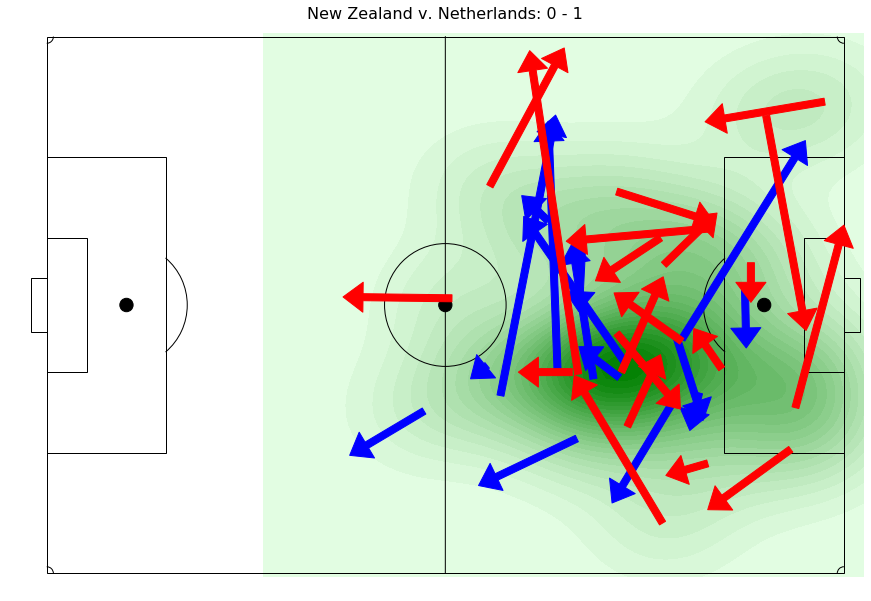

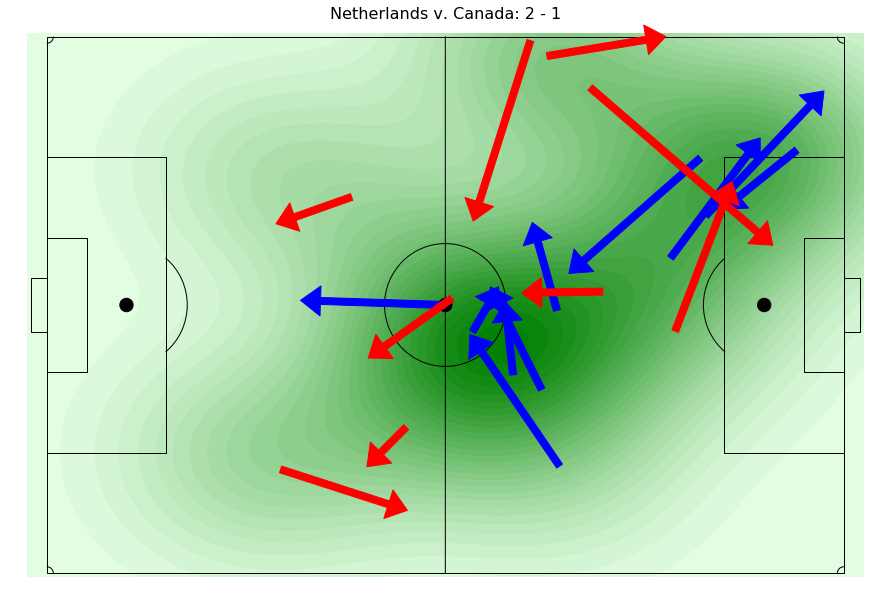

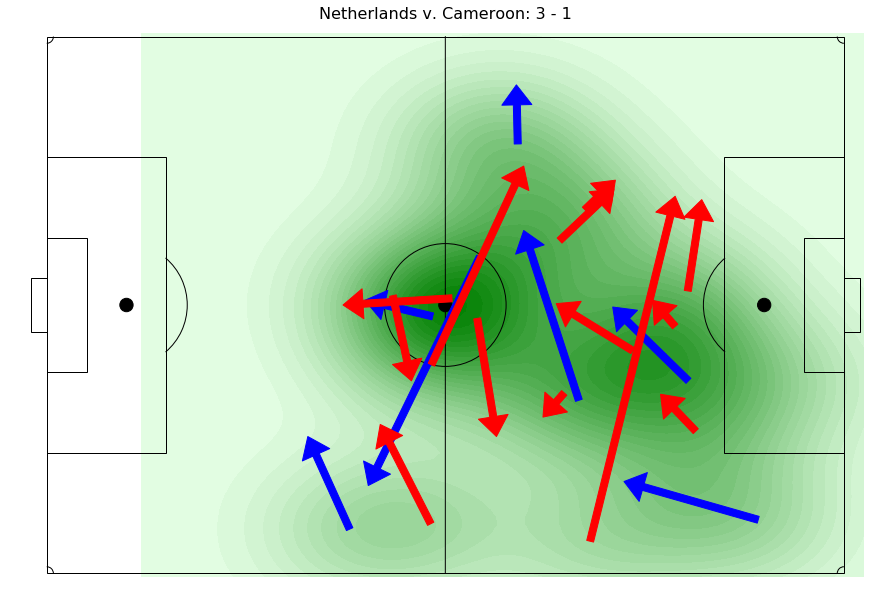

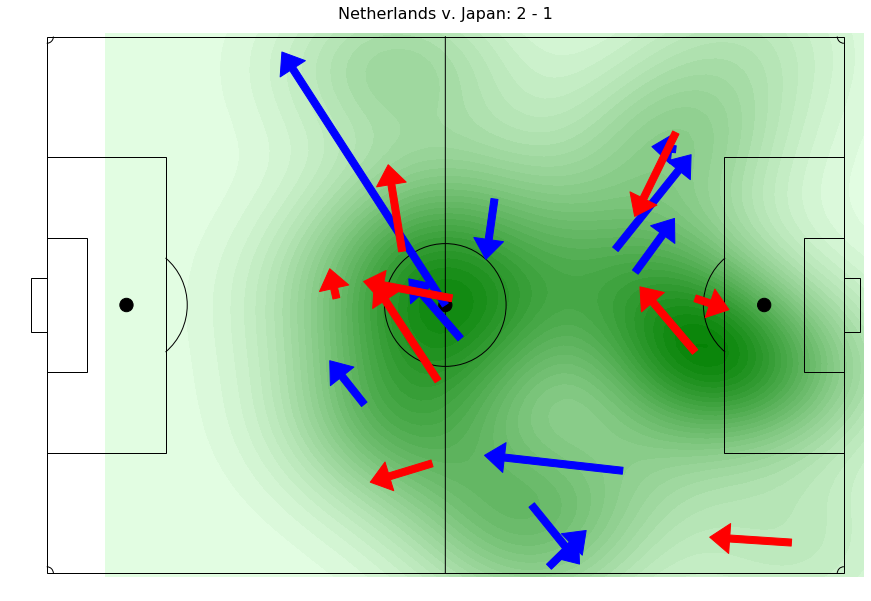

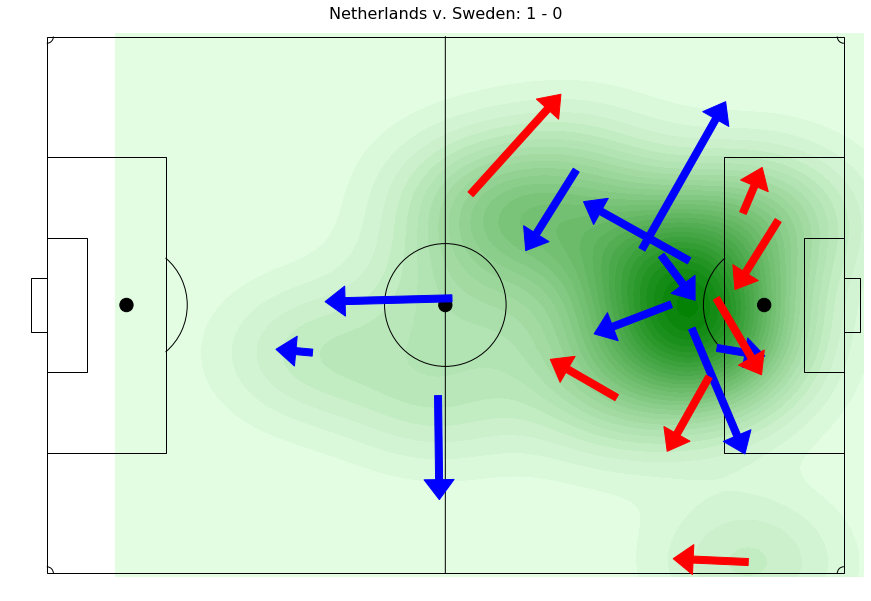

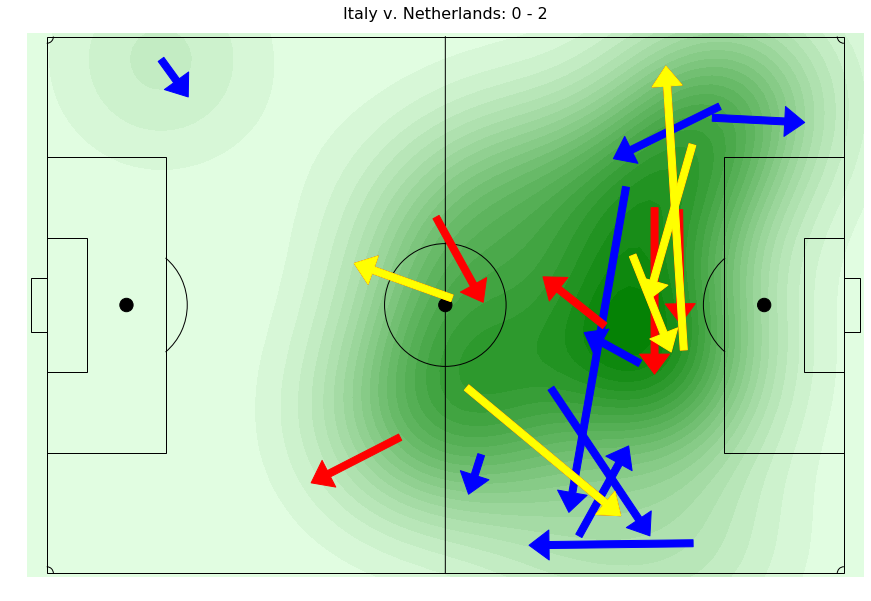

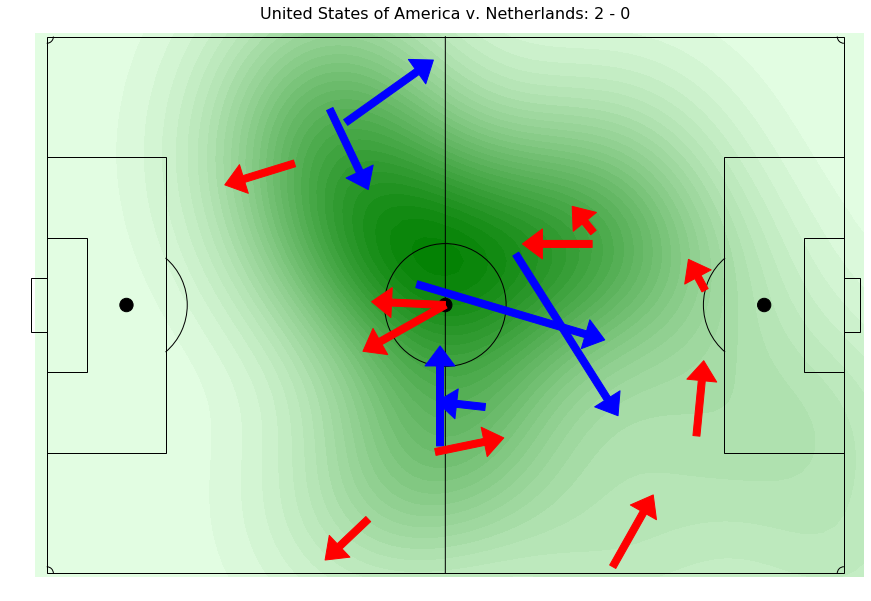

In [904]:
pass_map(matches, opponents, netherlands_games)

In [41]:
[column for column in data.columns if 'location' in column]

['carry.end_location', 'location', 'pass.end_location', 'shot.end_location']

In [327]:
def action_pie(matches, opponents, df = None):
    
    impt_events = ['Pass', 'Carry', 'Pressure', 'Dribble', 'Clearance', 'Ball Recovery', 'Block',
              'Shot', 'Interception']
    
    row = 1
    col = 1
    
    fig = make_subplots(rows=4, cols=2, subplot_titles = opponents, specs=[[{'type':'domain'}, {'type':'domain'}],
                                                                           [{'type':'domain'}, {'type':'domain'}],
                                                                           [{'type':'domain'}, {'type':'domain'}],
                                                                           [{'type':'domain'}, {'type':'domain'}]
                                                                          ])

    for i in range(len(matches)):
        
        actions = matches[i]['type.name'].value_counts().to_frame().reset_index()
        actions = actions.loc[actions['index'].isin(impt_events)]
        
        if type(df) == pd.DataFrame:
            title_string = (df.iloc[i]['home_team.country.name'] + " v. " + df.iloc[i]['away_team.country.name']\
                 + ": " + str(df.iloc[i]['home_score']) + ' - ' + str(df.iloc[i]['away_score']))
              
        if col < 3:
            fig.add_trace(go.Pie(labels = actions['index'], values = actions['type.name'], name = opponents[i]), row, col)
            
            col += 1
        else:
            col = 1
            row += 1
            
            fig.add_trace(go.Pie(labels = actions['index'], values = actions['type.name'], name = opponents[i]), row, col)
            
            col += 1
    
    layout=dict(title='Vivianne Miedema Throughout the World Cup',
    autosize = True,
    height = 1000,
    width = 900
    )
    
    fig.update_layout(layout)
        
    fig.show()

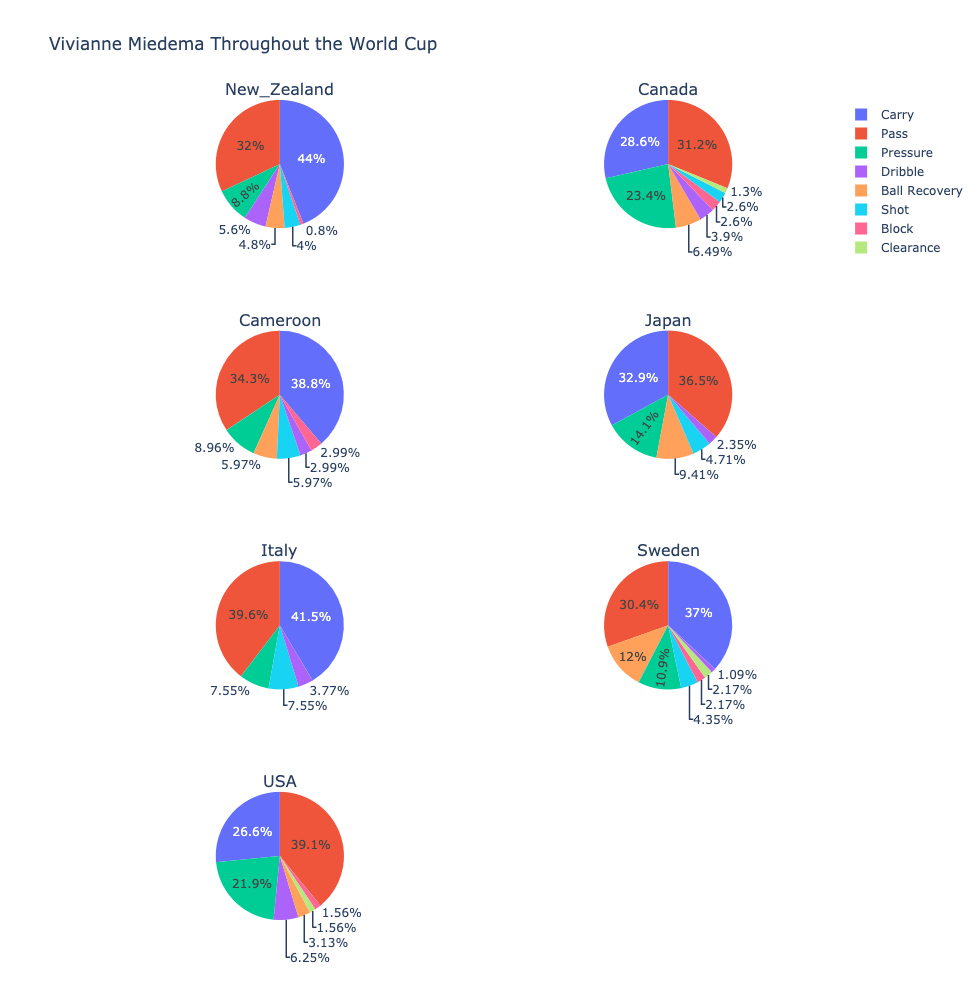

In [328]:
action_pie(matches, opponents, netherlands_games)

In [137]:
impt_events = ['Pass', 'Carry', 'Pressure', 'Dribble', 'Clearance', 'Ball Recovery', 'Block',
              'Duel', 'Shot', 'Interception']

In [843]:
Events(69321).print_players()

,player,position
0,Alex Morgan,Center Forward
1,Abby Dahlkemper,Right Center Back
2,Samantha Mewis,Left Center Midfield
3,Danielle van de Donk,Right Wing
4,Desiree van Lunteren,Right Back
5,Megan Rapinoe,Left Wing
6,Crystal Alyssia Dunn,Left Back
7,Jackie Groenen,Right Center Midfield
8,Becky Sauerbrunn,Left Center Back
9,Tobin Heath,Right Wing


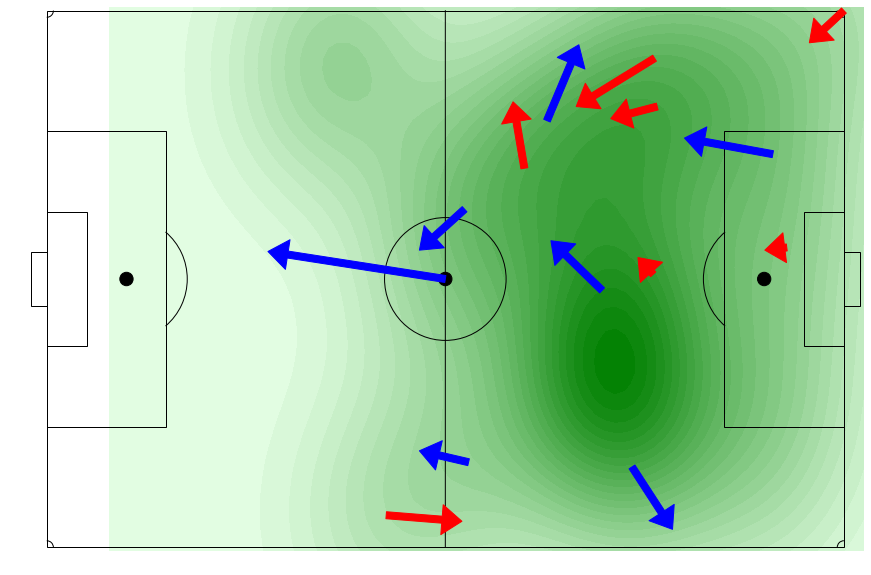

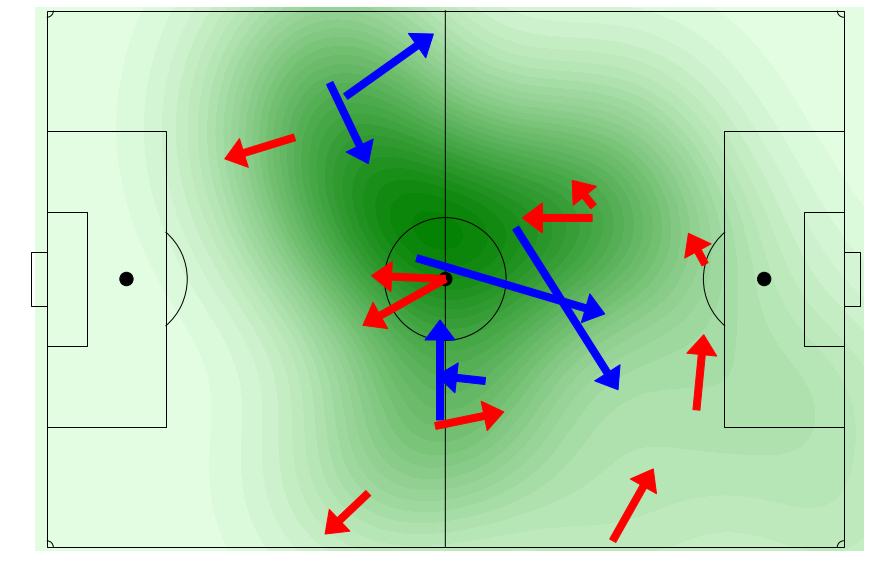

In [905]:
morgan = Events(match_id = 69321).get_player_data('Alex Morgan')
viv = Events(match_id = 69321).get_player_data('Vivianne Miedema')
strikers = [morgan, viv]
strk = ['Morgan', 'Viv']

pass_map(strikers, strk)

In [928]:
Events(match_id = 69321).get_player_data('Jackie Groenen')['type.name'].value_counts()

Ball Receipt*      44
Pass               42
Carry              34
Pressure           16
Ball Recovery       6
Dribble             4
Duel                3
Clearance           2
Dispossessed        1
Dribbled Past       1
Miscontrol          1
Block               1
Foul Won            1
Injury Stoppage     1
Shot                1
Name: type.name, dtype: int64

In [736]:
final_passes = Events(match_id = 69321).get_action_data('Pass')
final_passes.columns

Index(['counterpress', 'duration', 'id', 'index', 'location', 'minute',
       'off_camera', 'pass.aerial_won', 'pass.angle', 'pass.assisted_shot_id',
       'pass.body_part.id', 'pass.body_part.name', 'pass.cross',
       'pass.cut_back', 'pass.end_location', 'pass.goal_assist',
       'pass.height.id', 'pass.height.name', 'pass.inswinging', 'pass.length',
       'pass.outcome.id', 'pass.outcome.name', 'pass.outswinging',
       'pass.recipient.id', 'pass.recipient.name', 'pass.shot_assist',
       'pass.straight', 'pass.switch', 'pass.technique.id',
       'pass.technique.name', 'pass.through_ball', 'pass.type.id',
       'pass.type.name', 'period', 'play_pattern.id', 'play_pattern.name',
       'player.id', 'player.name', 'position.id', 'position.name',
       'possession', 'possession_team.id', 'possession_team.name',
       'related_events', 'second', 'team.id', 'team.name', 'timestamp',
       'type.id', 'type.name', 'under_pressure'],
      dtype='object')

In [734]:
final_passes['team.id'].unique()

array([1214,  851])

In [747]:
usa_passes = final_passes.loc[:, ['pass.outcome.name', 'player.name', 'pass.recipient.name', 'team.id']]
usa_passes.dropna(subset = ['pass.recipient.name'], inplace = True)
usa_passes = usa_passes.loc[usa_passes['pass.outcome.name'] != 'Incomplete']

starting_usa = ['Crystal Alyssia Dunn', 'Abby Dahlkemper', 'Becky Sauerbrunn', 'Kelley O"Hara',
               'Samantha Mewis', 'Julie Ertz', 'Rose Lavelle',
               'Tobin Heath', 'Alex Morgan', 'Megan Rapinoe',
               'Alyssa Naeher']

usa_passes = usa_passes.loc[usa_passes['team.id'] == 1214]
usa_passes = usa_passes.loc[(usa_passes['player.name'].isin(starting_usa)) & (usa_passes['pass.recipient.name'].isin(starting_usa))]
usa_passes['player.name'] = usa_passes['player.name'].apply(lambda x: x.split()[-1])
usa_passes['pass.recipient.name'] = usa_passes['pass.recipient.name'].apply(lambda x: x.split()[-1])

usa_passes.shape

(265, 4)

In [789]:
usa_touches = (usa_passes['player.name'].value_counts() + usa_passes['pass.recipient.name'].value_counts() ) * 50
usa_touches.to_dict()

{'Dahlkemper': 2550,
 'Dunn': 4050,
 'Ertz': 1900,
 'Heath': 2100,
 'Lavelle': 2400,
 'Mewis': 2500,
 'Morgan': 1900,
 'Naeher': 900,
 'O"Hara': 2300,
 'Rapinoe': 3000,
 'Sauerbrunn': 2900}

In [939]:
usa_pairs = [(usa_passes['player.name'][x], usa_passes['pass.recipient.name'][x]) for x in usa_passes.index]
usa_pairs = pd.Series(usa_pairs)
usa_pair_counts = usa_pairs.value_counts().to_frame('count')
usa_pair_counts = usa_pair_counts.reset_index()
usa_pair_counts['weight'] = usa_pair_counts['count'].apply(lambda x: str((x/usa_pair_counts['count'].sum()))[0:5])
usa_pair_counts['edge'] = usa_pair_counts.apply(lambda x: (x['index'][0], x['index'][1],  x['weight']), axis = 1)
usa_pair_counts = usa_pair_counts.loc[usa_pair_counts['count'] >= 3]

900 4050


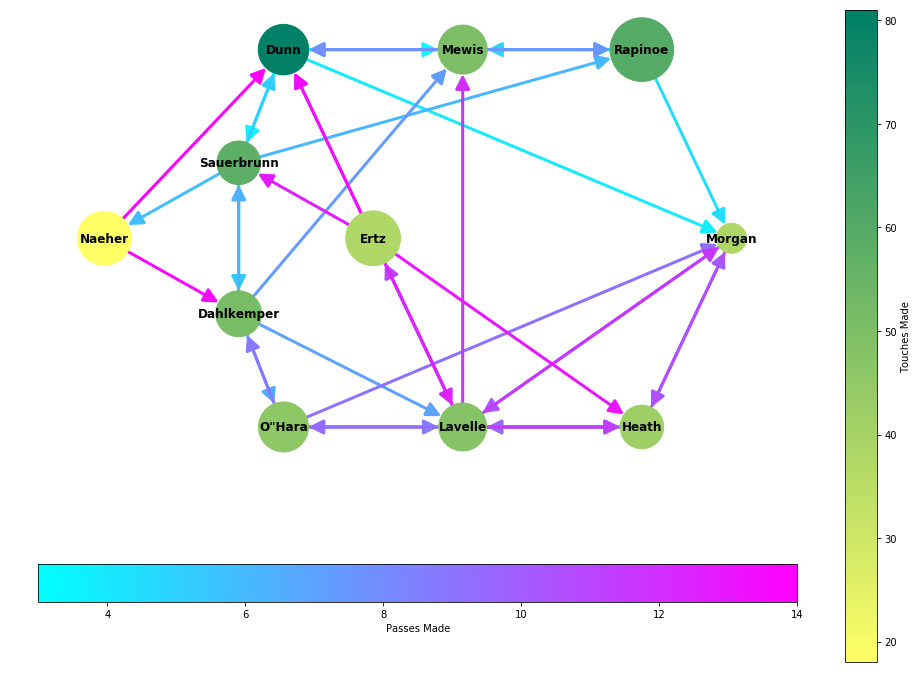

In [946]:
G = nx.DiGraph()

G.add_weighted_edges_from(usa_pair_counts['edge'].values)

fig = plt.figure()
fig.set_size_inches(17, 12)

fixed_positions = {'Naeher': (0, 0),
                  'Dunn': (1, 1), 'Sauerbrunn': (0.75, 0.4), 'Dahlkemper': (0.75, -0.4), 'O"Hara': (1, -1),
                  'Mewis': (2,1) , 'Ertz': (1.5, 0), 'Lavelle': (2, -1),
                  'Rapinoe': (3, 1), 'Morgan': (3.5,0), 'Heath':(3,-1)}

fixed_nodes = fixed_positions.keys()

nodes = G.nodes()
colors = [usa_touches[n] for n in nodes]
vmin = min(colors)
vmax = max(colors)
print(vmin, vmax)

pos = nx.spring_layout(G, pos = fixed_positions, fixed = fixed_nodes)

M = G.number_of_edges()
edge_colors = range(2, M + 2)
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]

weights = [G[u][v]['weight'] for u, v in G.edges() if u != v]

nx.draw_networkx_nodes(G, pos, with_labels = False, node_color = colors, node_size = usa_touches, cmap=plt.cm.summer_r,
                       vmin=vmin, vmax=vmax)

labels = {}    
for node in G.nodes():
    if node in fixed_nodes:
        #set the node name as the key and the label as its value 
        labels[node] = node

#Now only add labels to the nodes you require (the hubs in my case)
nx.draw_networkx_labels(G,pos,labels,font_size = 12,font_color='black', font_weight = 'bold')

# ec = nx.draw_networkx(G, pos, nodelist = nodes, node_size = touches, node_color = colors, cmap=plt.cm.Greens,
#                      vmin=vmin, vmax=vmax, font_color = 'black')
edges = nx.draw_networkx_edges(G, pos, node_size = touches, arrowstyle='-|>', arrowsize = 30, edge_color = edge_colors,
                                edge_cmap=plt.cm.cool, width = 3, alpha= 0.5)

sm = plt.cm.ScalarMappable(cmap=plt.cm.summer_r, norm=plt.Normalize(vmin=vmin/50, vmax=vmax/50))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Touches Made', color='black')

ab = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(vmin=3,
                                                                 vmax=usa_pair_counts['count'].max()))
ab.set_array([])
cbar1 = plt.colorbar(ab, orientation="horizontal")

cbar1.set_label('Passes Made', color='black')

font = {'family': 'sans serif',
            'color':  'black',
            'weight': 'normal',
            'size': 16,
            }
            
#plt.title("Women's World Cup Final: USA Pass Map", pad = 15, fontdict = font)

plt.axis('off')

plt.show()

filename = 'maps/' + 'usa' + '_pass.png'

fig.savefig(filename, transparent=True)

900 4050


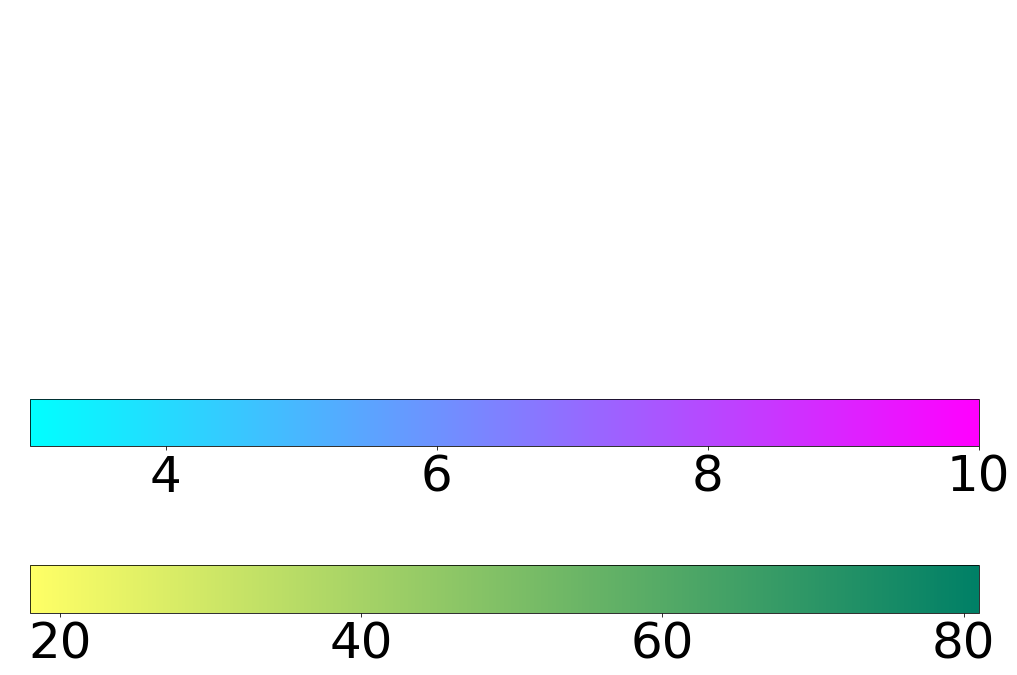

In [947]:
G = nx.DiGraph()

G.add_weighted_edges_from(usa_pair_counts['edge'].values)

fig = plt.figure()
fig.set_size_inches(17, 12)

fixed_positions = {'Naeher': (0, 0),
                  'Dunn': (1, 1), 'Sauerbrunn': (0.75, 0.4), 'Dahlkemper': (0.75, -0.4), 'O"Hara': (1, -1),
                  'Mewis': (2,1) , 'Ertz': (1.5, 0), 'Lavelle': (2, -1),
                  'Rapinoe': (3, 1), 'Morgan': (3.5,0), 'Heath':(3,-1)}

fixed_nodes = fixed_positions.keys()

nodes = G.nodes()
colors = [usa_touches[n] for n in nodes]
vmin = min(colors)
vmax = max(colors)
print(vmin, vmax)

sm = plt.cm.ScalarMappable(cmap=plt.cm.summer_r, norm=plt.Normalize(vmin=vmin/50, vmax=vmax/50))
sm.set_array([])
cbar = plt.colorbar(sm, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=50)
#cbar.set_label('Touches Made', color='black')

ab = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(vmin=ned_pair_counts['count'].min(),
                                                                 vmax=ned_pair_counts['count'].max()))
ab.set_array([])
cbar1 = plt.colorbar(ab, orientation = 'horizontal')
cbar1.ax.tick_params(labelsize=50) 

#cbar1.set_label('Passes Made', color='black')

font = {'family': 'sans serif',
            'color':  'black',
            'weight': 'normal',
            'size': 16,
            }
            
#plt.title("Women's World Cup Final: USA Pass Map", pad = 15, fontdict = font)

plt.axis('off')

plt.show()

filename = 'maps/' + 'bars_blank.png'

fig.savefig(filename, transparent=True)

In [788]:
ned_passes = final_passes.loc[:, ['pass.outcome.name', 'player.name', 'pass.recipient.name', 'team.id']]
ned_passes.dropna(subset = ['pass.recipient.name'], inplace = True)
ned_passes = ned_passes.loc[ned_passes['pass.outcome.name'] != 'Incomplete']

starting_ned = ['Dominique Johanna Anna Bloodworth', 'Stephanie van der Gragt', 'Anouk Dekker', 'Desiree van Lunteren',
               'Sherida Spitse', 'Danielle van de Donk', 'Jackie Groenen',
               'Lieke Martens', 'Vivianne Miedema', 'Lineth Beerensteyn',
               'Sari van Veenendaal']

ned_passes = ned_passes.loc[ned_passes['team.id'] == 851]
ned_passes = ned_passes.loc[(ned_passes['player.name'].isin(starting_ned)) & (ned_passes['pass.recipient.name'].isin(starting_ned))]
ned_passes['player.name'] = ned_passes['player.name'].apply(lambda x: x.split()[-1])
ned_passes['pass.recipient.name'] = ned_passes['pass.recipient.name'].apply(lambda x: x.split()[-1])

ned_passes.shape

(258, 4)

In [790]:
ned_touches = (ned_passes['player.name'].value_counts() + ned_passes['pass.recipient.name'].value_counts() ) * 50
ned_touches.to_dict()

{'Beerensteyn': 1550,
 'Bloodworth': 3100,
 'Dekker': 2200,
 'Donk': 2300,
 'Gragt': 2650,
 'Groenen': 3200,
 'Lunteren': 2950,
 'Martens': 1950,
 'Miedema': 1600,
 'Spitse': 3450,
 'Veenendaal': 850}

In [942]:
ned_pairs = [(ned_passes['player.name'][x], ned_passes['pass.recipient.name'][x]) for x in ned_passes.index]
ned_pairs = pd.Series(ned_pairs)
ned_pair_counts = ned_pairs.value_counts().to_frame('count')
ned_pair_counts = ned_pair_counts.reset_index()
ned_pair_counts['weight'] = ned_pair_counts['count'].apply(lambda x: str((x/ned_pair_counts['count'].sum()))[0:5])
ned_pair_counts['edge'] = ned_pair_counts.apply(lambda x: (x['index'][0], x['index'][1],  x['weight']), axis = 1)
ned_pair_counts = ned_pair_counts.loc[ned_pair_counts['count'] >= 3]

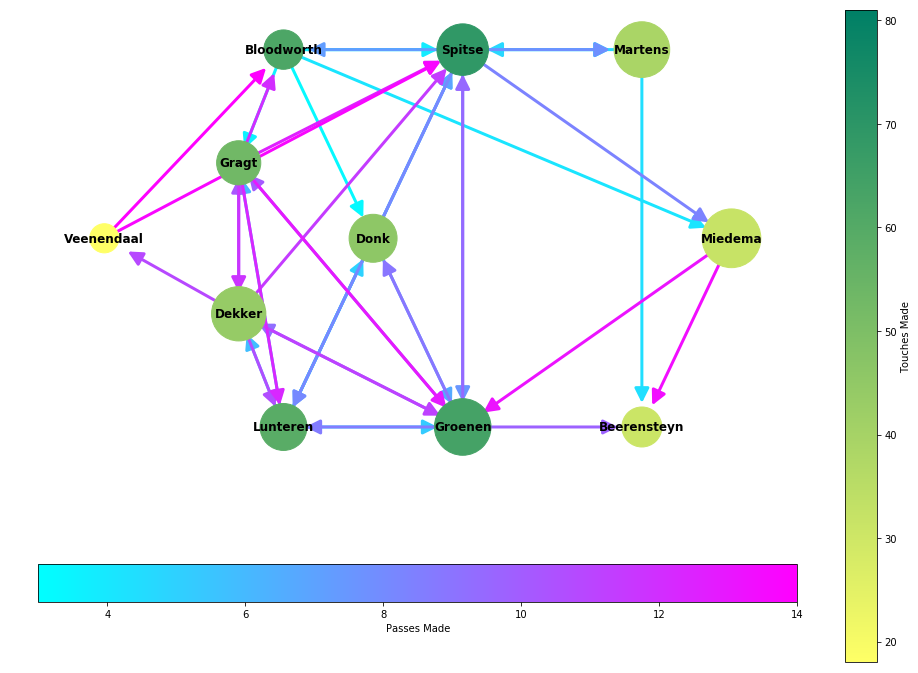

In [948]:
G = nx.DiGraph()

G.add_weighted_edges_from(ned_pair_counts['edge'].values)

fig = plt.figure()
fig.set_size_inches(17, 12)

fixed_positions = {'Veenendaal': (0, 0),
                  'Bloodworth': (1, 1), 'Gragt': (0.75, 0.4), 'Dekker': (0.75, -0.4), 'Lunteren': (1, -1),
                  'Spitse': (2,1) , 'Donk': (1.5, 0), 'Groenen': (2, -1),
                  'Martens': (3, 1), 'Miedema': (3.5,0), 'Beerensteyn':(3,-1)}

fixed_nodes = fixed_positions.keys()

nodes = G.nodes()
colors = [ned_touches[n] for n in nodes]
vmin = 900#min(colors)
vmax = 4050#max(colors)

pos = nx.spring_layout(G, pos = fixed_positions, fixed = fixed_nodes)

M = G.number_of_edges()
edge_colors = range(2, M + 2)

nx.draw_networkx_nodes(G, pos, with_labels = False, node_color = colors, node_size = ned_touches, cmap=plt.cm.summer_r,
                 vmin=vmin, vmax=vmax)

labels = {}    
for node in G.nodes():
    if node in fixed_nodes:
        #set the node name as the key and the label as its value 
        labels[node] = node

#Now only add labels to the nodes you require (the hubs in my case)
nx.draw_networkx_labels(G,pos,labels,font_size = 12,font_color='black', font_weight = 'bold')

# ec = nx.draw_networkx(G, pos, nodelist = nodes, node_size = touches, node_color = colors, cmap=plt.cm.Greens,
#                      vmin=vmin, vmax=vmax, font_color = 'black')
edges = nx.draw_networkx_edges(G, pos, node_size = touches, arrowstyle='-|>', arrowsize= 30, edge_color = edge_colors,
                                edge_cmap=plt.cm.cool, width = 3, alpha= 0.5)

sm = plt.cm.ScalarMappable(cmap=plt.cm.summer_r, norm=plt.Normalize(vmin=vmin/50, vmax=vmax/50))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Touches Made', color='black')


ab = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(vmin=3,
                                                                 vmax=usa_pair_counts['count'].max()))
ab.set_array([])
cbar1 = plt.colorbar(ab, orientation="horizontal")

cbar1.set_label('Passes Made', color='black')

font = {'family': 'sans serif',
            'color':  'black',
            'weight': 'normal',
            'size': 16,
            }
            
#plt.title("Women's World Cup Final: Netherlands Pass Map", pad = 15, fontdict = font)

plt.axis('off')

plt.show()

filename = 'maps/' + 'ned' + '_pass.png'

fig.savefig(filename, transparent=True)

In [817]:
pass_per = final_passes['team.name'].value_counts('percentage')
incomplete_passes = final_passes.loc[final_passes['pass.outcome.name'] == 'Incomplete']\
['team.name'].value_counts('percentage')

Netherlands Women's      0.526786
United States Women's    0.473214
Name: team.name, dtype: float64